In [1]:
DATE = "2022-01-26"
TASK = "sample-core-genome"
DIR = mkpath("$(homedir())/workspace/$(DATE)-$(TASK)")
cd(DIR)

In [2]:
pkgs = [
    "Graphs",
    "MetaGraphs",
    "FileIO",
    "JLD2",
    "DataStructures",
    "BioSequences",
    "Random",
    "FASTX",
    "Revise",
    "StatsBase"
]

import Pkg
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $(basename(pkg))"))
end

import Mycelia

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/dev/Mycelia/docs/Project.toml`
  No Changes to `~/.julia/dev/Mycelia/docs/Manifest.toml`


In [3]:
function kmer_path_to_sequence(kmer_path)
    sequence = BioSequences.LongDNASeq(first(kmer_path))
    for kmer in kmer_path[2:end]
        @assert kmer[1] == sequence[end-1]
        @assert kmer[2] == sequence[end]
        push!(sequence, kmer[end])
    end
    return sequence
end

kmer_path_to_sequence (generic function with 1 method)

In [4]:
# vertices should either be entire graph (by default) or a connected component
# if people want to work on just the connected component, let them induce a subgraph
function find_graph_core(graph; seed=rand(Int))
    
    Random.seed!(seed)
    
    T = typeof(MetaGraphs.get_prop(graph, 1, :kmer))
    
    # take the hub nodes!
    selected_nodes = [
        MetaGraphs.get_prop(graph, i, :kmer) for (i, v) in enumerate(Graphs.vertices(graph))
            if Graphs.degree(graph, v) >= 3]    
    selected_node_counts = [MetaGraphs.get_prop(graph, :kmer_counts)[kmer] for kmer in selected_nodes]
    starting_node = StatsBase.sample(selected_nodes, StatsBase.weights(selected_node_counts))
    current_walk = [starting_node]

    prior_walk_length = length(current_walk)
    
    targets = setdiff(selected_nodes, current_walk)
    remaining_targets = Set{T}(vcat(targets, BioSequences.reverse_complement.(targets)))
    done = isempty(remaining_targets)
    
    while !done
        forward_source = last(current_walk)
        reverse_source = BioSequences.reverse_complement(first(current_walk))
        forward_walk, forward_distance = Mycelia.dijkstra(graph, forward_source, remaining_targets, search_strategy=:DFS)
        reverse_walk, reverse_distance = Mycelia.dijkstra(graph, reverse_source, remaining_targets, search_strategy=:DFS)

        current_walk = vcat(reverse(BioSequences.reverse_complement.(reverse_walk))[1:end-1], current_walk, forward_walk[2:end])
        
        # assess whether targets have been hit in the canonical space
        remaining_targets = setdiff(BioSequences.canonical.(remaining_targets), BioSequences.canonical.(current_walk))
        # blow back out into forward and reverse_complement space
        remaining_targets = Set{T}(vcat(remaining_targets, BioSequences.reverse_complement.(remaining_targets)))    
        failed_this_expansion = length(current_walk) == prior_walk_length
        prior_walk_length = length(current_walk)
        
        if isempty(remaining_targets)
            done = true
        elseif failed_this_expansion
            done = true
        end
    end

    forward_source = last(current_walk)
    reverse_source = BioSequences.reverse_complement(first(current_walk))
    forward_walk, forward_distance = Mycelia.dijkstra(graph, forward_source, remaining_targets, search_strategy=:DFS)
    reverse_walk, reverse_distance = Mycelia.dijkstra(graph, reverse_source, remaining_targets, search_strategy=:DFS)
    current_walk = vcat(reverse(BioSequences.reverse_complement.(reverse_walk))[1:end-1], current_walk, forward_walk[2:end])
    return current_walk
end     

find_graph_core (generic function with 1 method)

In [5]:
# Create a reference sequence
refseq = BioSequences.randdnaseq(Random.seed!(2), 9)

9nt DNA Sequence:
CGCCCACCG

In [6]:
altseq = copy(refseq)
altseq[5] = BioSequences.DNA_T
altseq

9nt DNA Sequence:
CGCCTACCG

In [7]:
fasta_file = "$(DIR)/test.fasta"
open(fasta_file, "w") do io
    fastx_io = FASTX.FASTA.Writer(io)
    i = 1
    for x in 1:2
        write(fastx_io, FASTX.FASTA.Record("$i", refseq))
        i += 1
    end
    write(fastx_io, FASTX.FASTA.Record("$i", altseq))
    close(fastx_io)
end
println(read(fasta_file, String))

>1
CGCCCACCG
>2
CGCCCACCG
>3
CGCCTACCG



In [8]:
k = 3
T = BioSequences.BigDNAMer{3}

BioSequences.BigDNAMer{3} (alias for BioSequences.BigMer{BioSequences.DNAAlphabet{2}, 3})

In [9]:
graph = Mycelia.fastx_to_kmer_graph(T, fasta_file)

┌ Info: counting kmers
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:78


  1.217342 seconds (1.94 M allocations: 105.282 MiB, 4.09% gc time, 91.97% compilation time)


┌ Info: initializing graph
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:81
┌ Info: adding node metadata
└ @ Mycelia /home/jupyter-cjprybol/.julia/dev/Mycelia/src/graph-construction.jl:91
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


{10, 10} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

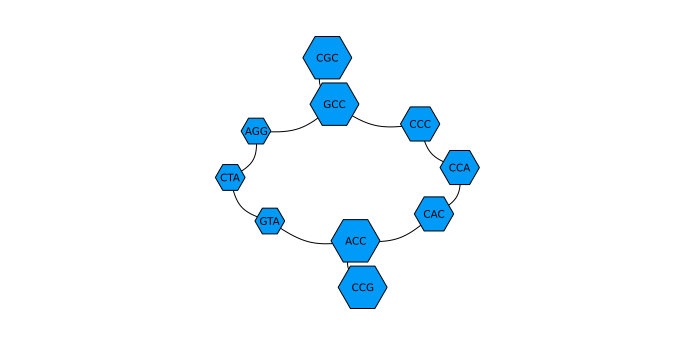

In [10]:
Mycelia.plot_graph(graph)

In [11]:
seed = 0
core_path = find_graph_core(graph, seed=seed)

7-element Vector{BioSequences.BigDNAMer{3}}:
 CGC
 GCC
 CCC
 CCA
 CAC
 ACC
 CCG

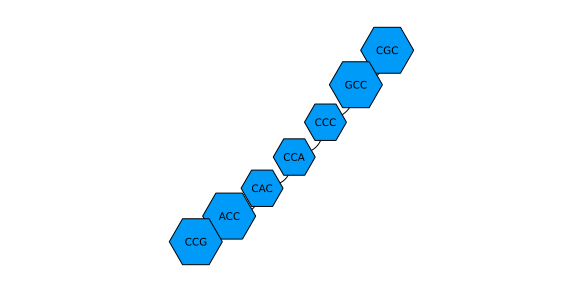

In [12]:
selected_vertices = map(canonical_kmer -> graph[canonical_kmer, :kmer], unique(BioSequences.canonical.(core_path)))
subgraph, vertex_map = Graphs.induced_subgraph(graph, selected_vertices)
Mycelia.plot_graph(subgraph)

In [13]:
reconstruted_sequence = kmer_path_to_sequence(core_path)

9nt DNA Sequence:
CGCCCACCG

In [14]:
refseq

9nt DNA Sequence:
CGCCCACCG

In [15]:
Mycelia.is_equivalent(reconstruted_sequence, refseq)

true

In [37]:
seed += 1
@show seed
core_path = find_graph_core(graph, seed=seed)

seed = 22


7-element Vector{BioSequences.BigDNAMer{3}}:
 CGC
 GCC
 CCC
 CCA
 CAC
 ACC
 CCG

In [38]:
# works every time!!!!